# This notebook aims to fill missing data from the wildfire dataset

In [1]:
# All imports for the project goes here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from helpers import feature_plot, oneHotEnc_to_classes, parse_datetime_features_to_hours, RocCallback
from helpers import datetime_feature_engineering, fill_datetime_with_neighbors, save_model, load_model
from helpers import fire_number_feature_engineering, data_analysis_by_size_class
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import category_encoders as ce
from datetime import datetime
from sklearn.preprocessing import StandardScaler, RobustScaler
from helpers import feature_plot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV


%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Loading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Parsing date data to datetime type
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

In [4]:
# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      7194
activity_class                  6197
fuel_type                       4793
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

In [5]:
# Test missing data
null_counts = test.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      1796
activity_class                  1524
fuel_type                       1247
fire_fighting_start_date        1080
discovered_date                  546
weather_conditions_over_fire     456
fire_position_on_slope           456
fire_type                        434
fire_start_date                  112
fire_origin                        3
dtype: int64

In [208]:
# Get training data only with non null rows
noNaN_train = train.dropna()

In [209]:
datetime_feature_engineering(noNaN_train)

,fire_number,fire_year,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,det_agent_type,...,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,fire_duration,time_to_ex,fire_fight_response_time,time_to_discover,time_to_report
4,SWF001,2009,A,55.905933,-113.578850,Indian Reservation,Resident,Piles,Permit Related,UNP,...,FPD Staff,Surface,Flat,Clear,C2,1395.0,1161.0,75.0,45.0,0.0
41,SWF216,2009,B,54.932783,-115.210783,Provincial Land,Power Line Industry,Power Lines,Unpredictable Event,UNP,...,HAC1H,Surface,Flat,Cloudy,C2,1253.0,1203.0,5.0,3.0,0.0
44,HWF044,2006,B,58.496423,-115.123148,Indian Reservation,Resident,Grass,Permit Related,LKT,...,HAC1F,Surface,Flat,Clear,O1a,1155.0,1115.0,30.0,10.0,0.0
53,HWF036,2009,A,58.720683,-118.696617,Indian Reservation,Resident,Children,Burning Substance,UNP,...,HAC1H,Surface,Flat,Clear,O1a,2269.0,2267.0,2.0,0.0,0.0
68,HWF034,2011,B,58.452807,-114.579165,Indian Reservation,Resident,Grass,Permit Related,LKT,...,FPD Staff,Surface,Flat,CB Dry,O1a,2660.0,2610.0,20.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15847,LWF009,2013,B,55.917117,-110.736367,Indian Reservation,Resident,Debris Disposal,Unsafe Fire,LKT,...,FPD Staff,Surface,Flat,Clear,O1a,1188.0,1147.0,38.0,3.0,0.0
15859,SWF050,2008,C,55.464667,-114.796350,Provincial Park,Power Line Industry,Power Lines,Unpredictable Event,LKT,...,Air Tanker,Crown,Middle 1/3,Cloudy,M2,54342.0,51810.0,150.0,2.0,0.0
15861,GWF159,2008,A,54.859544,-118.777492,Provincial Land,Power Line Industry,Power Lines,Insufficient Buffer,UNP,...,FPD Staff,Surface,Flat,Clear,O1b,142.0,5.0,14.0,124.0,0.0
15863,SWF202,2006,A,55.949617,-113.730433,Provincial Land,Recreation,All Terrain Vehicles,Hot Exhaust,LKT,...,HAC1H,Surface,Flat,Clear,M2,935.0,865.0,30.0,15.0,0.0


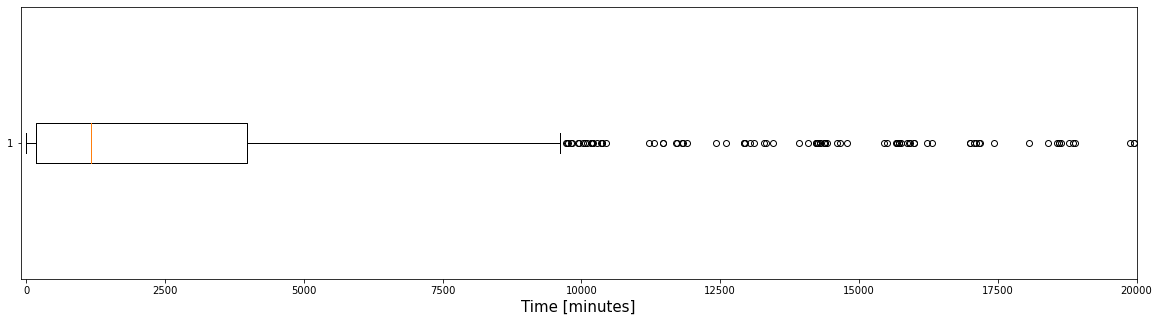

In [210]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_train)['fire_duration'], vert=False)
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-100,20000]);

In [211]:
#plt.figure(figsize=(20,5))
#plt.boxplot(datetime_feature_engineering(noNaN_train)['time_to_ex'], vert=False);
#plt.xlabel('Time [minutes]', fontsize=15)
#plt.xlim([-100,20000]);

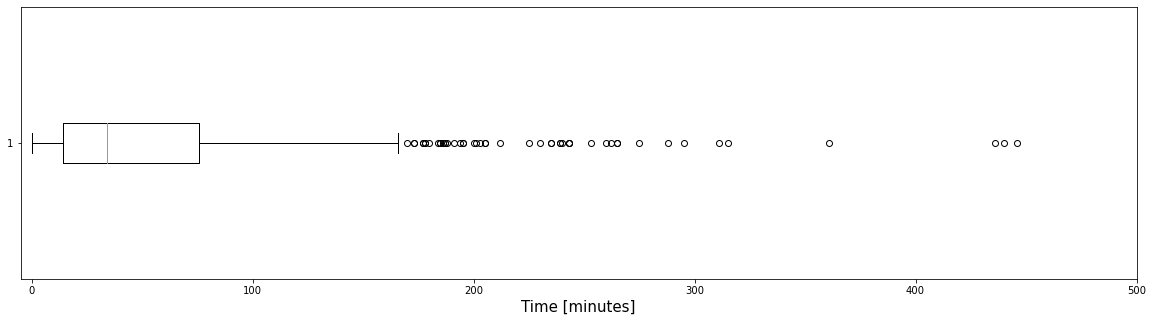

In [212]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_train)['fire_fight_response_time'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-5,500]);

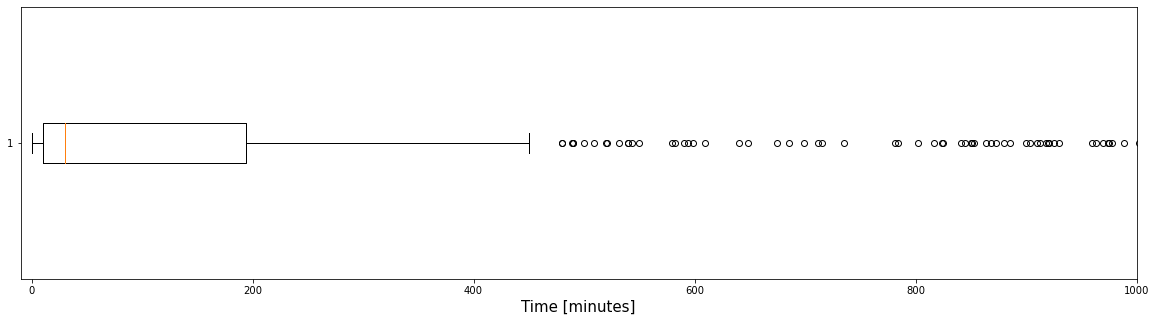

In [213]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_train)['time_to_discover'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-10,1000]);

In [214]:
# Get training data only with non null rows
noNaN_test = test.dropna()
datetime_feature_engineering(noNaN_test)

,fire_number,fire_year,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,det_agent_type,det_agent,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,fire_duration,time_to_ex,fire_fight_response_time,time_to_discover,time_to_report
1,WWF031,2008,54.186250,-115.175200,Provincial Land,Recreation,All Terrain Vehicles,Burning Substance,LKT,IM,HAC1H,Surface,Flat,Clear,M2,2719.0,2590.0,60.0,15.0,0.0
17,RWF051,2009,52.462913,-115.095227,Provincial Land,Power Line Industry,Power Lines,Insufficient Buffer,LKT,RY,FPD Staff,Surface,Flat,Cloudy,O1a,444.0,328.0,28.0,83.0,0.0
31,CWF117,2018,51.142300,-114.721217,Provincial Land,Resident,Transportation,Vehicle Fire,GRP,PATR,FPD Staff,Surface,Flat,Cloudy,O1b,50.0,20.0,0.0,10.0,0.0
32,CWF209,2016,50.184933,-114.319600,Provincial Land,Recreation,Cooking and Warming,Unsafe Fire,UNP,LFS,FPD Staff,Surface,Bottom,Clear,D1,2674.0,1594.0,1041.0,39.0,0.0
33,PWF010,2010,56.477417,-116.414167,Provincial Land,Resident,Children,Burning Substance,UNP,LFS,FPD Staff,Ground,Flat,Clear,O1a,398.0,181.0,22.0,195.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,LWF008,2012,55.931817,-110.725767,Indian Reservation,Resident,Debris Disposal,Unsafe Fire,UNP,LFS,FPD Staff,Surface,Flat,Clear,O1b,1180.0,1122.0,2.0,58.0,0.0
3947,SWF123,2010,55.636133,-116.402533,Provincial Land,Resident,Unclassified,Unattended Fire,UNP,310,HAC1H,Surface,Flat,CB Dry,M2,2440.0,1217.0,19.0,1205.0,0.0
3959,HWF017,2008,58.717650,-118.746317,Indian Reservation,Resident,Grass,Abandoned Fire,LKT,ZA,HAC1H,Surface,Flat,Cloudy,O1a,264.0,126.0,114.0,26.0,0.0
3960,MWF005,2016,56.163967,-111.744100,Provincial Land,Other Industry,Debris Disposal,Winter Burning,LKT,AL,HAC,Surface,Flat,Clear,S1,102381.0,1311.0,71.0,101014.0,0.0


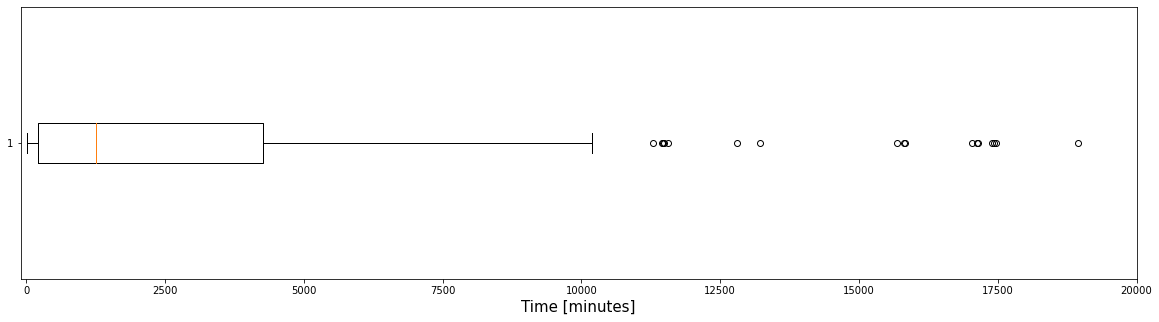

In [215]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_test)['fire_duration'], vert=False)
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-100,20000]);

In [216]:
#plt.figure(figsize=(20,5))
#plt.boxplot(datetime_feature_engineering(noNaN_test)['time_to_ex'], vert=False);
#plt.xlabel('Time [minutes]', fontsize=15)
#plt.xlim([-100,20000]);

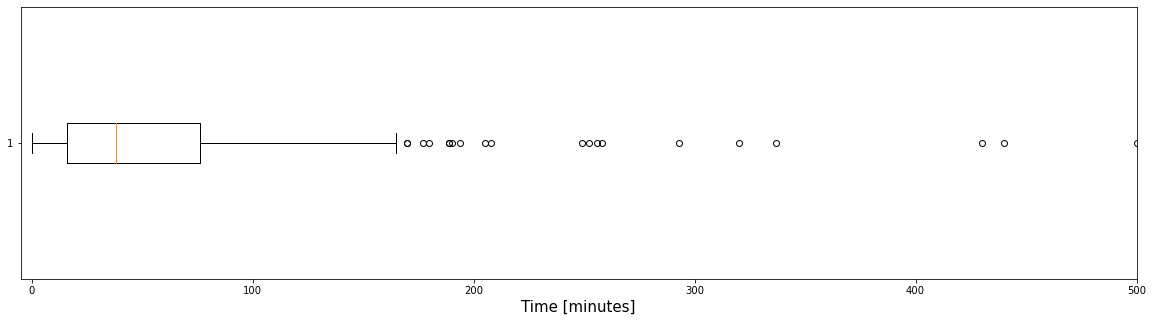

In [217]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_test)['fire_fight_response_time'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-5,500]);

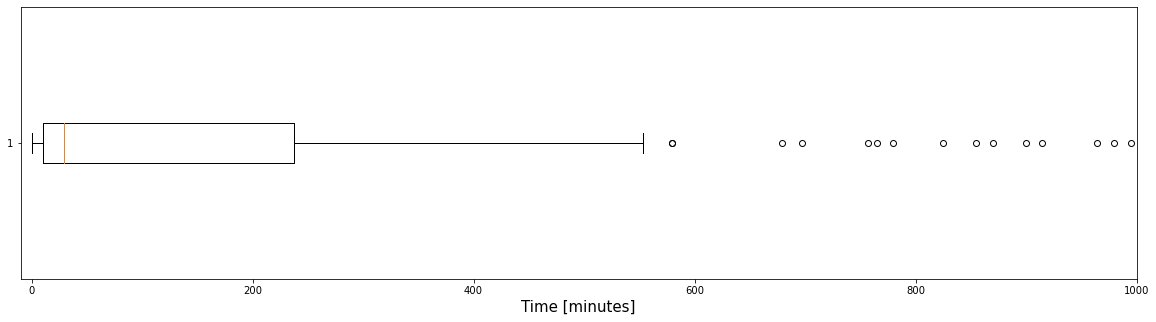

In [218]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_test)['time_to_discover'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-10,1000]);

# Build model to fill Fuel categorical data

In [219]:
# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      7194
activity_class                  6197
fuel_type                       4793
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

**Note:** One of the highest unknown featues is the fuel_type which represents The predominate fuel type (vegetation cover) in which the wildfire is burning, at the time of initial assessment. The classes of this feature can be the following:

Group: Coniferous
* `C1:` Spruce-Lichen Woodland
* `C2:` Boreal Spruce
* `C3:` Mature Jack or Lodgepole Pine
* `C4:` Immature Jack or Lodgepole Pine
* `C7:` Conifer plantation

Group: Mixedwood
* `M1:` Boreal Mixedwood-Leafless
* `M2:` Boreal Mixedwood-Green

Group: Slash
* `S1:` Jack or Lodgepole Pine slash
* `S2:` White Spruce-Balsam slash

Group: Deciduous
* `D1:` Leafless Aspen

Group: Grass
* `O1a:` Matted Grass
* `O1b:` Standing Grass

In [230]:
# train non null fuel indexes
nan_fuel_indx_train = ~train['fuel_type'].isnull()
# test non null fuel indexes
nan_fuel_indx_test = ~test['fuel_type'].isnull()
## join the datasets: train + test datasets
full_dataset = pd.concat([train.drop(['size_class'], 1)[nan_fuel_indx_train], 
           test[nan_fuel_indx_test]])
## Get the features and labels
X = full_dataset.drop(['fuel_type'], 1)
y = full_dataset['fuel_type']

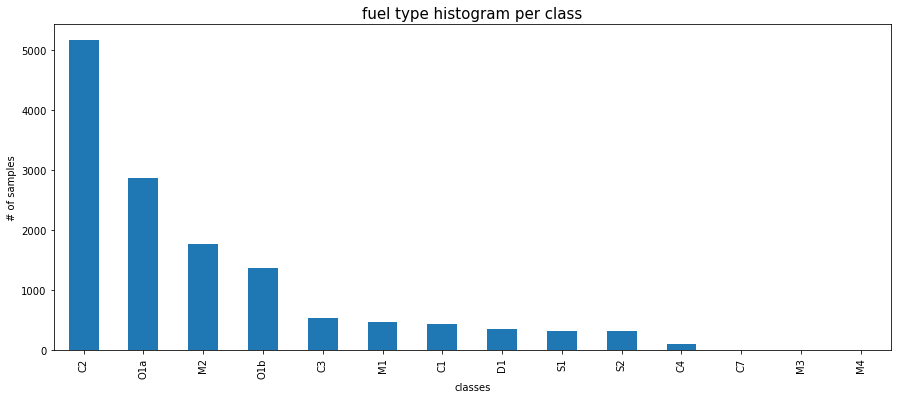

C2     5173
O1a    2878
M2     1776
O1b    1380
C3      538
M1      478
C1      446
D1      350
S1      331
S2      329
C4      112
C7       10
M3        2
M4        1
Name: fuel_type, dtype: int64

In [231]:
plt.figure(figsize=(15,6))
full_dataset['fuel_type'].value_counts().plot(kind='bar');
plt.title('fuel type histogram per class', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
full_dataset['fuel_type'].value_counts()

In [232]:
## Fill unknown data
fill_datetime_with_neighbors(X)
X.fillna('Unknown', inplace=True)

In [233]:
## feature engineering
X = datetime_feature_engineering(X)
X = fire_number_feature_engineering(X)
X.drop(['fire_number'], 1, inplace=True)

In [235]:
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X = ohe.fit_transform(X)

In [236]:
# standarized dataset
standardize = RobustScaler()
X[X.columns]=standardize.fit_transform(X)

In [237]:
# get rid of very low classes
no_M4_M3_C7_indx = (y!='M4') & (y!='M3') &((y!='C7'))

In [238]:
train_X, validation_X, train_y, validation_y = train_test_split(X[no_M4_M3_C7_indx], y[no_M4_M3_C7_indx], 
                                                                test_size=0.25, random_state=2, 
                                                                stratify=y[no_M4_M3_C7_indx])

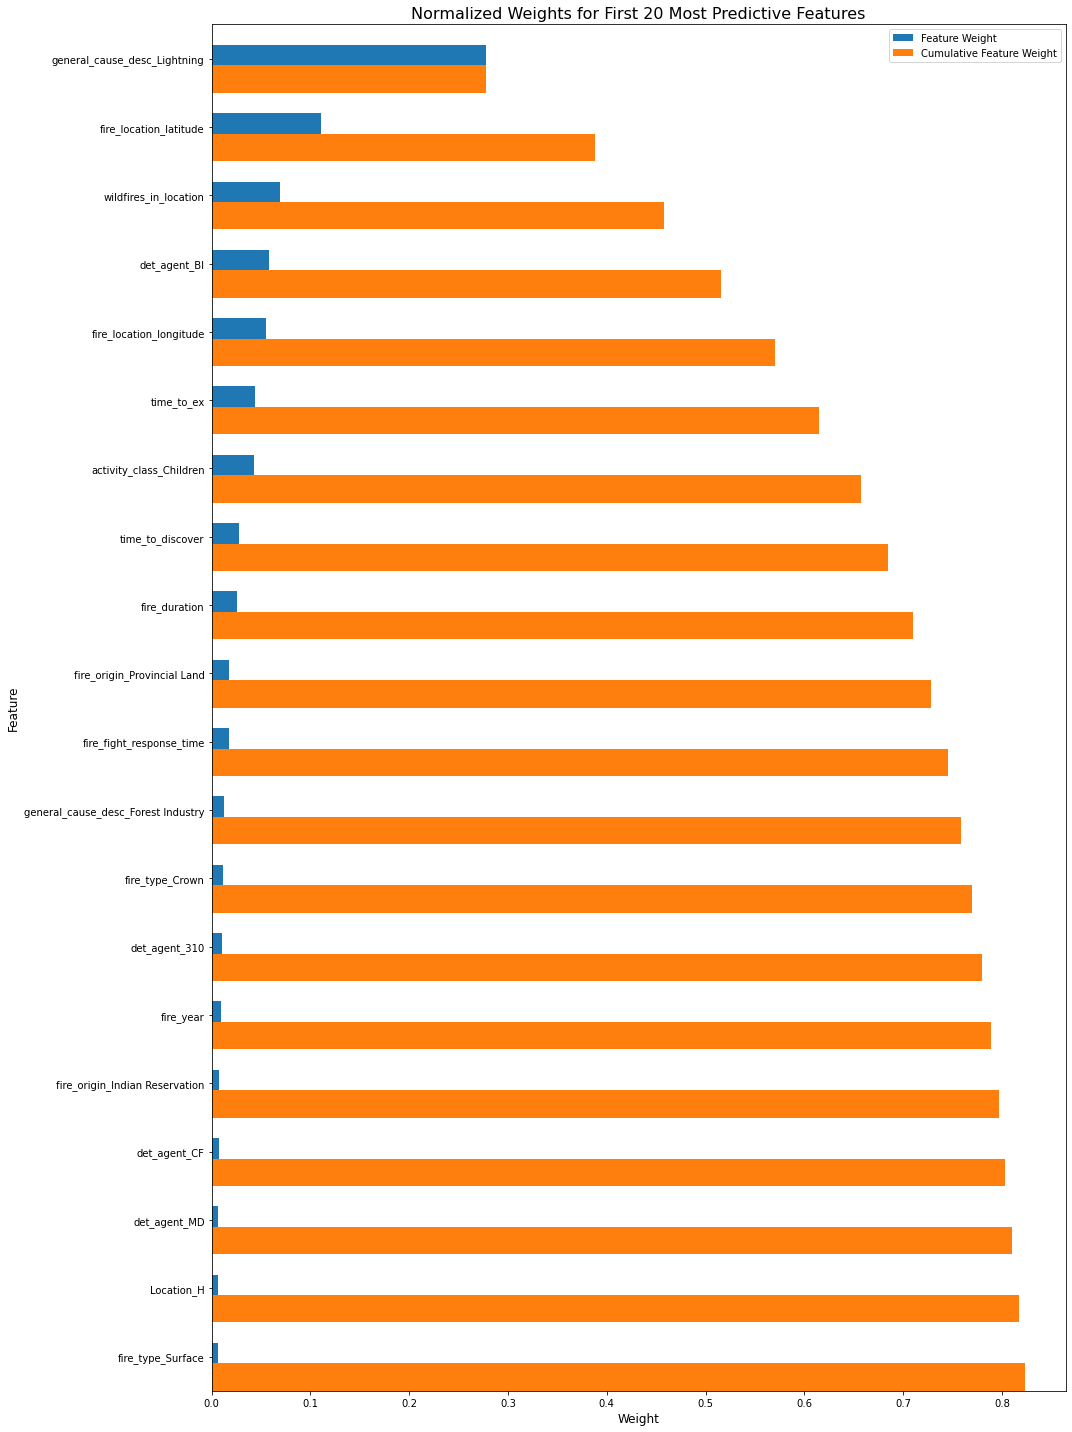

,Features,Importance value
0,general_cause_desc_Lightning,0.278039
1,fire_location_latitude,0.110454
2,wildfires_in_location,0.069341
3,det_agent_BI,0.057842
4,fire_location_longitude,0.054870
5,time_to_ex,0.043769
6,activity_class_Children,0.043227
7,time_to_discover,0.027331
8,fire_duration,0.025225
9,fire_origin_Provincial Land,0.017988


In [240]:
model = GradientBoostingClassifier(random_state=42, learning_rate=0.5, n_estimators=50, 
                                   max_depth=3)
model.fit(train_X.values, train_y.values.ravel())

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
relevant_df = feature_plot(importances, train_X, train_y, top_k=20)
relevant_df

In [244]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
# define model
"""Best model so far"""
#model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced_subsample',
#                              criterion='entropy', max_features=20, min_impurity_decrease=0.003) 
""""""
#model = BalancedRandomForestClassifier(n_estimators=100, max_depth=10,
#                                       random_state=42, class_weight='balanced_subsample',
#                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003)
#model = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.5, 
#                                                                         n_estimators=50, max_depth=3,
#                                                                        max_features=15), 
#                                n_estimators=10, random_state=42)
#model = RUSBoostClassifier(random_state=42,  learning_rate=0.1, n_estimators=300)
#model = RUSBoostClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced_subsample', max_depth=10,
#                                                                criterion='entropy', max_features=15),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)
model = RUSBoostClassifier(RandomForestClassifier(random_state=42, n_estimators=100, 
                                   max_depth=10, class_weight = 'balanced_subsample',
                              criterion='entropy', max_features=None, min_impurity_decrease=0.003),
                           random_state=42,  learning_rate=0.1, n_estimators=10)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate model
scores = cross_val_score(model, X[no_M4_M3_C7_indx], y[no_M4_M3_C7_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean f1-score: %.3f' % np.mean(scores))

Mean f1-score: 0.306


In [245]:
## Fit model
model.fit(train_X, train_y.values.ravel())

## predict using fit model
pred_validation_y = model.predict(validation_X)
f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(validation_y.values.ravel(), pred_validation_y)
gmean_score_sparse = geometric_mean_score(validation_y.values.ravel(), pred_validation_y, average=None)
print(f"F1-score - validation:{f1_score}")
print(f"Geometric mean - validation:{gmean_score}")
print(f"Geometric mean per class - validation:{gmean_score_sparse}")

print("-------------------------------------------------------------------------------------------")
pred_train_y = model.predict(train_X)
f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(train_y.values.ravel(), pred_train_y)
gmean_score_sparse = geometric_mean_score(train_y.values.ravel(), pred_train_y, average=None)
print(f"F1-score - train:{f1_score}")
print(f"Geometric mean - train:{gmean_score}")
print(f"Geometric mean per class - train:{gmean_score_sparse}")

F1-score - validation:0.323740679953299
Geometric mean - validation:0.3192290914328409
Geometric mean per class - validation:[0.45012472 0.7690534  0.63803773 0.46141876 0.49902866 0.42956401
 0.47323424 0.70049208 0.60586743 0.48530566 0.64462666]
-------------------------------------------------------------------------------------------
F1-score - train:0.4362411759878878
Geometric mean - train:0.46670274066767853
Geometric mean per class - train:[0.46900514 0.77414741 0.70692229 0.82142259 0.74716859 0.5812634
 0.45575132 0.72019756 0.68568335 0.70461976 0.78625166]


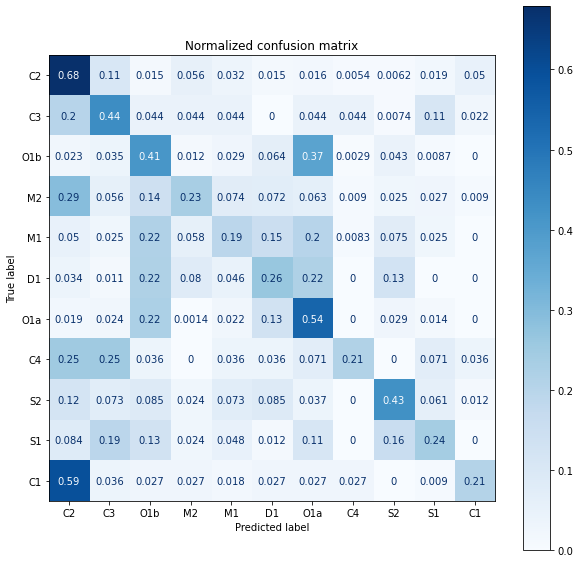

In [246]:
from sklearn.metrics import plot_confusion_matrix

class_names = validation_y.unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Normalized confusion matrix", 'true')]

fig, ax = plt.subplots(figsize=(10, 10))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, validation_X, validation_y.values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, ax=ax)
    disp.ax_.set_title(title)

plt.show()

## Predicting on missing data to fill their values

In [255]:
# null fuel_type indexes for training dataset
nan_fuel_indx_train = train['fuel_type'].isnull()
# null fuel_type indexes for testing dataset
nan_fuel_indx_test = test['fuel_type'].isnull()

In [257]:
## Preprocess data
train_features = train.drop(['size_class', 'fuel_type'], 1)[nan_fuel_indx_train]
test_features = test.drop(['fuel_type'], 1)[nan_fuel_indx_test]

## Fill unknown data
fill_datetime_with_neighbors(train_features)
train_features.fillna('Unknown', inplace=True)

fill_datetime_with_neighbors(test_features)
test_features.fillna('Unknown', inplace=True)

## feature engineering
train_features = datetime_feature_engineering(train_features)
train_features = fire_number_feature_engineering(train_features)
train_features.drop(['fire_number'], 1, inplace=True)

test_features = datetime_feature_engineering(test_features)
test_features = fire_number_feature_engineering(test_features)
test_features.drop(['fire_number'], 1, inplace=True)

## One hot encode data
#ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
train_features = ohe.transform(train_features)
test_features = ohe.transform(test_features)

## standarized dataset
standardize = RobustScaler()
train_features[train_features.columns]=standardize.fit_transform(train_features)

standardize = RobustScaler()
test_features[test_features.columns]=standardize.fit_transform(test_features)

In [249]:
inx = [s not in train_X.columns for s in train_features.columns]
train_features.columns[inx]

Index([], dtype='object')

In [250]:
## predicting values
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

In [251]:
pd.DataFrame({'test':pred_test})['test'].value_counts()

C2    766
M2    219
C3    151
C1     90
C4     14
S1      6
S2      1
Name: test, dtype: int64

In [252]:
pd.DataFrame({'train':pred_train})['train'].value_counts()

C2    3212
M2     798
C3     400
C1     335
C4      33
S1       8
S2       6
M1       1
Name: train, dtype: int64

In [258]:
# Saving the model
save_model('./fuel_model2.pkl', model)

In [259]:
# Loading the model
model2 = load_model('./fuel_model2.pkl')

In [260]:
test_prr = model2.predict(test_features)
pd.DataFrame({'test2':test_prr})['test2'].value_counts()

C2    766
M2    219
C3    151
C1     90
C4     14
S1      6
S2      1
Name: test2, dtype: int64

## fill dataset and save it with model

In [261]:
## non null indexes
non_null_indx_train = ~train['fuel_type'].isnull()
non_null_indx_test = ~test['fuel_type'].isnull()

In [262]:
## null indexes
null_indx_train = train['fuel_type'].isnull()
null_indx_test = test['fuel_type'].isnull()

#### Non null data

In [263]:
train[non_null_indx_train].fuel_type.value_counts()

C2     4125
O1a    2325
M2     1435
O1b    1127
C3      428
M1      378
C1      364
D1      278
S2      269
S1      253
C4       89
C7        8
M3        2
M4        1
Name: fuel_type, dtype: int64

In [264]:
test[non_null_indx_test].fuel_type.value_counts()

C2     1048
O1a     553
M2      341
O1b     253
C3      110
M1      100
C1       82
S1       78
D1       72
S2       60
C4       23
C7        2
Name: fuel_type, dtype: int64

#### Null data

In [265]:
train[null_indx_train].fuel_type.isnull().value_counts()

True    4793
Name: fuel_type, dtype: int64

In [266]:
test[null_indx_test].fuel_type.isnull().value_counts()

True    1247
Name: fuel_type, dtype: int64

### Filling data

In [267]:
train.loc[null_indx_train, 'fuel_type'] = model.predict(train_features)
test.loc[null_indx_test, 'fuel_type'] = model.predict(test_features)

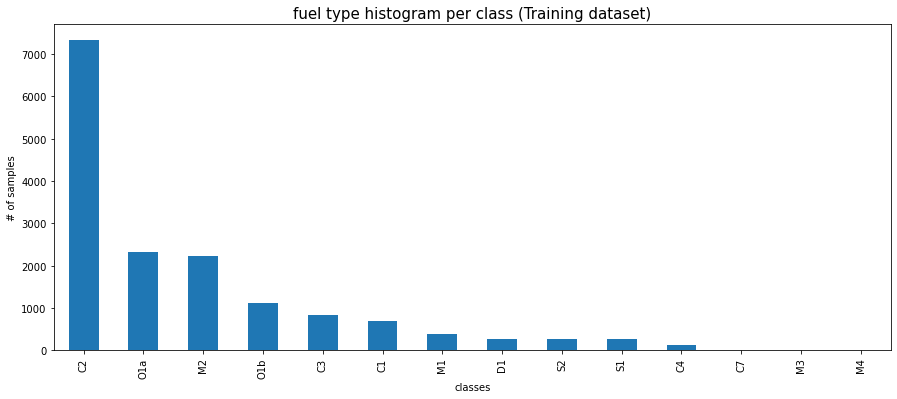

C2     7337
O1a    2325
M2     2233
O1b    1127
C3      828
C1      699
M1      379
D1      278
S2      275
S1      261
C4      122
C7        8
M3        2
M4        1
Name: fuel_type, dtype: int64

In [268]:
plt.figure(figsize=(15,6))
train['fuel_type'].value_counts().plot(kind='bar');
plt.title('fuel type histogram per class (Training dataset)', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
train['fuel_type'].value_counts()

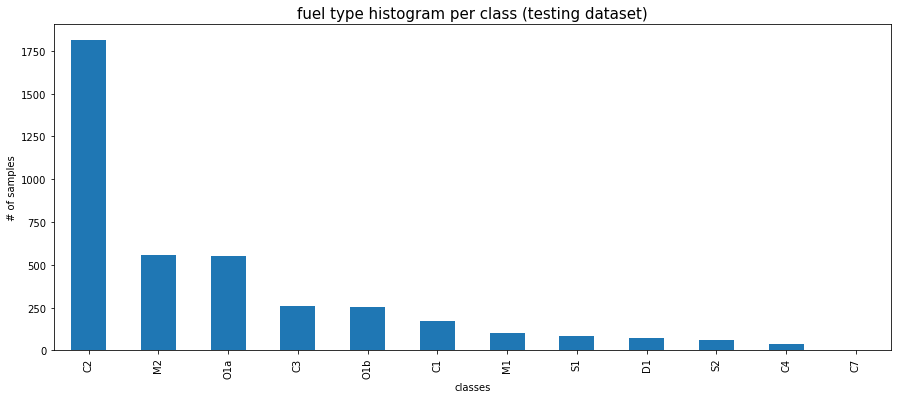

C2     1814
M2      560
O1a     553
C3      261
O1b     253
C1      172
M1      100
S1       84
D1       72
S2       61
C4       37
C7        2
Name: fuel_type, dtype: int64

In [269]:
plt.figure(figsize=(15,6))
test['fuel_type'].value_counts().plot(kind='bar');
plt.title('fuel type histogram per class (testing dataset)', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
test['fuel_type'].value_counts()

## saving data back to csv Files

In [270]:
file_name = 'train_fuel2.csv'
train.to_csv(file_name, encoding='utf-8', index=False)

In [271]:
file_name = 'test_fuel2.csv'
test.to_csv(file_name, encoding='utf-8', index=False)

## visualize data